# Scene generation

## JSON to JSON (generate similar scenes)

Check the statistics of a scene first

In [1]:
import json
import math
import numpy as np
from pathlib import Path

# ============
# 1) 配置
# ============
SCENE_JSON = Path("/home/jhuang52/Projects/metaRL_merged/scenarios/raleigh_buildings.json")  # TODO: 改成你的
GRID_N = 10                 # 先随便设一个 n（之后我们可以从场景尺度/建筑密度自动选）
N_BINS = 6                  # logspace 桶数量（不含两端inf；实际 bins = N_BINS+1 个区间）
EPS = 1e-9

# ============
# 2) 读 JSON
# ============
cfg = json.loads(SCENE_JSON.read_text(encoding="utf-8"))
buildings = cfg.get("buildings", [])
assert len(buildings) > 0, "buildings 为空"

print("Loaded:", SCENE_JSON)
print("Top keys:", list(cfg.keys()))
print("Num buildings:", len(buildings))

# ============
# 3) 提取 footprint area & centers
# ============
def polygon_area_xy(fp):
    # fp: list of [x,y]
    # shoelace; polygon doesn't need to be closed
    xs = np.array([p[0] for p in fp], dtype=np.float64)
    ys = np.array([p[1] for p in fp], dtype=np.float64)
    if len(xs) < 3:
        return 0.0
    # close
    x2 = np.r_[xs, xs[0]]
    y2 = np.r_[ys, ys[0]]
    return 0.5 * abs(np.dot(x2[:-1], y2[1:]) - np.dot(y2[:-1], x2[1:]))

areas = []
centers = []
xmins=[]; xmaxs=[]; ymins=[]; ymaxs=[]
for b in buildings:
    fp = b.get("footprint")
    if not fp or len(fp) < 3:
        continue
    a = polygon_area_xy(fp)
    areas.append(a)

    # center: prefer json center if exists else footprint centroid approx
    if "center" in b and b["center"] is not None:
        cx, cy = float(b["center"][0]), float(b["center"][1])
    else:
        pts = np.array(fp, dtype=np.float64)
        cx, cy = float(pts[:,0].mean()), float(pts[:,1].mean())
    centers.append((cx, cy))

    # bounds: prefer json xmin/xmax/ymin/ymax
    xmins.append(float(b.get("xmin", min(p[0] for p in fp))))
    xmaxs.append(float(b.get("xmax", max(p[0] for p in fp))))
    ymins.append(float(b.get("ymin", min(p[1] for p in fp))))
    ymaxs.append(float(b.get("ymax", max(p[1] for p in fp))))

areas = np.array(areas, dtype=np.float64)
centers = np.array(centers, dtype=np.float64)

print("Valid buildings with footprint:", len(areas))
print("Area stats: min/median/max =", float(areas.min()), float(np.median(areas)), float(areas.max()))

# ============
# 4) 定义工作 bounds（先用 buildings bbox）
# ============
xmin, xmax = float(min(xmins)), float(max(xmaxs))
ymin, ymax = float(min(ymins)), float(max(ymaxs))
W, H = xmax - xmin, ymax - ymin
scene_area = max(W * H, EPS)

print("\nScene bounds (from buildings bbox):")
print("xmin/xmax =", xmin, xmax)
print("ymin/ymax =", ymin, ymax)
print("W,H,Area  =", W, H, scene_area)

# 覆盖率（总footprint面积 / scene bbox面积）
built_ratio = float(areas.sum() / scene_area)
print("Built-up ratio (sum footprint / bbox area):", built_ratio)

# ============
# 5) logspace 分桶（基于面积）
# ============
a_min = max(float(areas.min()), 1e-3)
a_max = max(float(areas.max()), a_min * 1.001)

bins = np.logspace(np.log10(a_min), np.log10(a_max), num=N_BINS+1)  # 边界数组长度 N_BINS+1
# 为了覆盖极端值，我们加上 [0, +inf] 两端
bins_full = np.r_[0.0, bins[1:-1], np.inf]  # 保留中间边界
# 注：这样实际区间数 = len(bins_full)-1 = N_BINS
# 如果你希望更多/更少桶，改 N_BINS

hist_counts, edges = np.histogram(areas, bins=bins_full)
hist_ratio = hist_counts / max(hist_counts.sum(), 1)

print("\nArea bins (logspace, with 0..inf):")
for i in range(len(edges)-1):
    lo, hi = edges[i], edges[i+1]
    print(f"  bin{i}: [{lo:.3g}, {hi:.3g})  count={hist_counts[i]}  ratio={hist_ratio[i]:.3f}")

# ============
# 6) 网格占用统计（每格多少栋）
# ============
# centers -> grid cell
gx = np.clip(((centers[:,0] - xmin) / max(W, EPS) * GRID_N).astype(int), 0, GRID_N-1)
gy = np.clip(((centers[:,1] - ymin) / max(H, EPS) * GRID_N).astype(int), 0, GRID_N-1)

grid_counts = np.zeros((GRID_N, GRID_N), dtype=int)
for ix, iy in zip(gx, gy):
    grid_counts[iy, ix] += 1  # 注意这里用 [row=y, col=x]

print("\nGrid occupancy (GRID_N x GRID_N) summary:")
print("max buildings in one cell:", int(grid_counts.max()))
print("mean buildings per non-empty cell:", float(grid_counts[grid_counts>0].mean()) if np.any(grid_counts>0) else 0.0)
print("non-empty cells:", int((grid_counts>0).sum()), "/", GRID_N*GRID_N)

# 打印一个简单的“稀疏展示”
print("\nNon-empty cells (y,x,count):")
for (iy, ix) in zip(*np.where(grid_counts>0)):
    print(f"  ({iy},{ix}) -> {grid_counts[iy,ix]}")

# ============
# 7) （可选）网格 x 面积桶 的占用：每个格子里各桶多少栋
# ============
# 先给每栋分桶 id
bin_ids = np.digitize(areas, edges[1:-1], right=False)  # 返回 0..N_BINS-1
# grid_bin_counts[y, x, bin]
grid_bin_counts = np.zeros((GRID_N, GRID_N, len(hist_counts)), dtype=int)
for ix, iy, bid in zip(gx, gy, bin_ids):
    grid_bin_counts[iy, ix, bid] += 1

print("\nExample: one cell's bin counts (pick the densest cell):")
densest = np.unravel_index(np.argmax(grid_counts), grid_counts.shape)
iy, ix = densest
print("densest cell (y,x) =", densest, "count =", grid_counts[iy,ix])
print("bin counts in densest cell:", grid_bin_counts[iy,ix,:].tolist())


Loaded: /home/jhuang52/Projects/metaRL_merged/scenarios/raleigh_buildings.json
Top keys: ['meta', 'buildings']
Num buildings: 924
Valid buildings with footprint: 924
Area stats: min/median/max = 0.0 22.209664410038386 13952.367050764151

Scene bounds (from buildings bbox):
xmin/xmax = -776.8180541992188 739.359130859375
ymin/ymax = -597.7220458984375 623.6837768554688
W,H,Area  = 1516.1771850585938 1221.4058227539062 1851867.6421571933
Built-up ratio (sum footprint / bbox area): 0.1725552663651736

Area bins (logspace, with 0..inf):
  bin0: [0, 0.0155)  count=184  ratio=0.199
  bin1: [0.0155, 0.241)  count=118  ratio=0.128
  bin2: [0.241, 3.74)  count=85  ratio=0.092
  bin3: [3.74, 58)  count=143  ratio=0.155
  bin4: [58, 899)  count=320  ratio=0.346
  bin5: [899, inf)  count=74  ratio=0.080

Grid occupancy (GRID_N x GRID_N) summary:
max buildings in one cell: 28
mean buildings per non-empty cell: 9.333333333333334
non-empty cells: 99 / 100

Non-empty cells (y,x,count):
  (0,0) -> 6
  

NB_DIR       = /data/jhuang52/Projects/metaRL_merged/outer_loop
PROJECT_ROOT = /data/jhuang52/Projects/metaRL_merged
sys.path[0]  = /data/jhuang52/Projects/metaRL_merged
json_path = /data/jhuang52/Projects/metaRL_merged/scenarios/raleigh_buildings.json


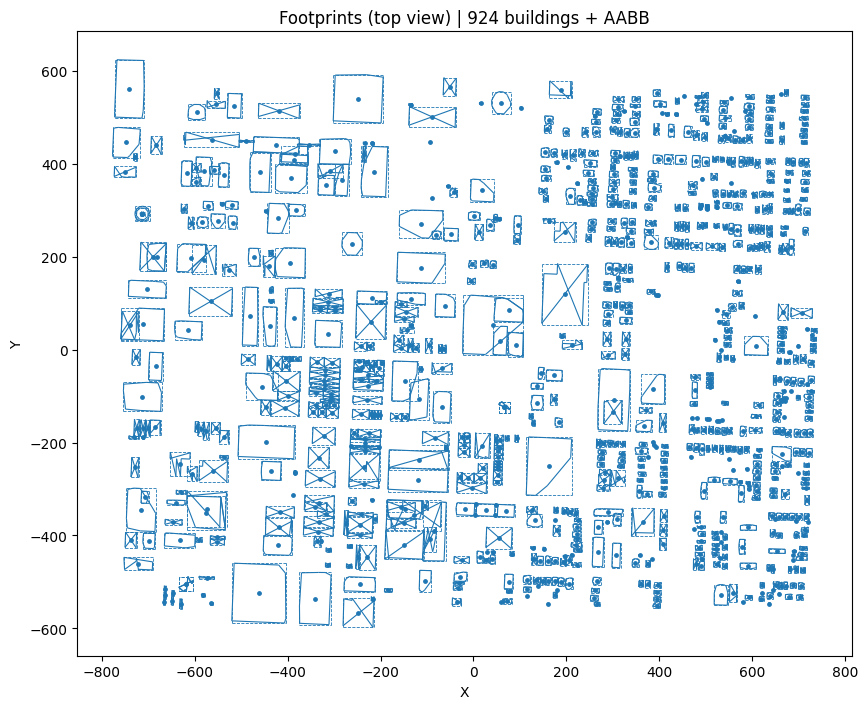

In [2]:
from pathlib import Path
import sys

# 你的 notebook 在：Projects/metaRL_merged/outer_loop/scenario_adaptation.ipynb
NB_DIR = Path.cwd().resolve()
PROJECT_ROOT = NB_DIR.parent  # -> Projects/metaRL_merged

if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

print("NB_DIR       =", NB_DIR)
print("PROJECT_ROOT =", PROJECT_ROOT)
print("sys.path[0]  =", sys.path[0])

from notebook_utils import plot_footprints_2d

SCEN_DIR = PROJECT_ROOT / "scenarios"
json_path = SCEN_DIR / "raleigh_buildings.json"

print("json_path =", json_path)
assert json_path.exists(), f"Not found: {json_path}"

plot_footprints_2d(
    str(json_path),
    max_buildings=2000,
    show_aabb=True,
    show_centers=True,
)


Loaded: /home/jhuang52/Projects/metaRL_merged/scenarios/raleigh_buildings.json
Top keys: ['meta', 'buildings']
Num buildings total: 924
Valid buildings used: 785
Area stats: min/median/max = 0.0010051978752017021 59.086459428071976 13952.367050764151

Scene bounds (from buildings bbox):
xmin/xmax = -776.8180541992188 739.359130859375
ymin/ymax = -597.7220458984375 623.6837768554688
W,H,Area  = 1516.1771850585938 1221.4058227539062 1851867.6421571933
Built-up ratio (sum footprint / bbox area): 0.1725552575057993

Area bins (logspace, with 0..inf):
  bin0: [0, 0.0156)  count=45  ratio=0.057
  bin1: [0.0156, 0.242)  count=118  ratio=0.150
  bin2: [0.242, 3.74)  count=85  ratio=0.108
  bin3: [3.74, 58.1)  count=143  ratio=0.182
  bin4: [58.1, 900)  count=320  ratio=0.408
  bin5: [900, inf)  count=74  ratio=0.094

Grid occupancy summary:
grid_n: 10
max buildings in one cell: 28
mean buildings per non-empty cell: 7.929292929292929
non-empty cells: 99 / 100

Densest cell (y,x) = (7, 8) count 

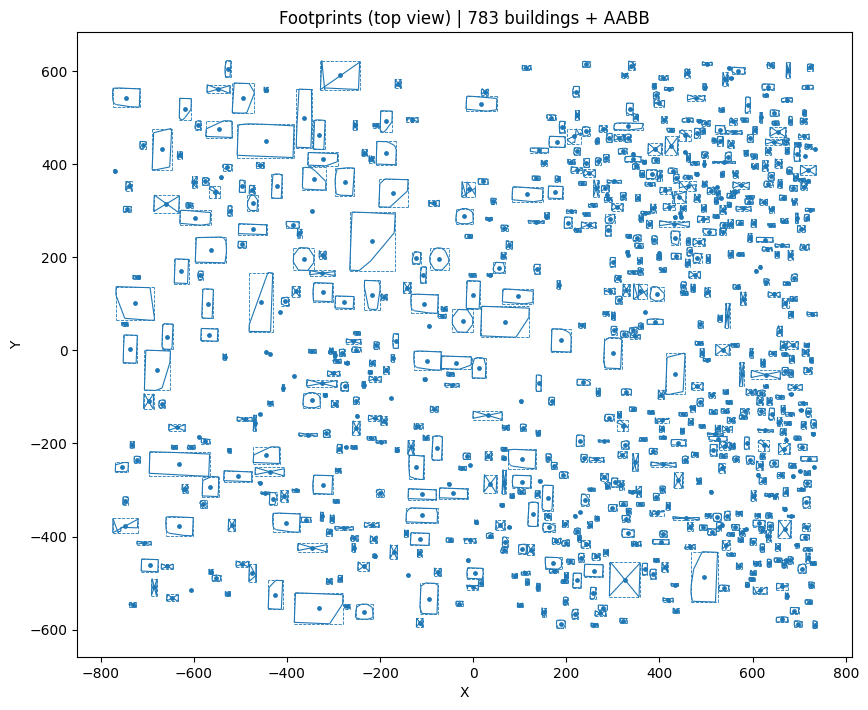

In [3]:
from scene_json_to_json import generate_similar_buildings_json

generate_similar_buildings_json(
    proto_json_path="/home/jhuang52/Projects/metaRL_merged/scenarios/raleigh_buildings.json",
    out_json_path="/home/jhuang52/Projects/metaRL_merged/scenarios/raleigh_buildings_sim1.json",
    grid_n=10,
    n_bins=6,
    min_area_eps=1e-3,
    seed=0,
)


plot_footprints_2d(
    # str(json_path),
    "/home/jhuang52/Projects/metaRL_merged/scenarios/raleigh_buildings_sim1.json",
    max_buildings=2000,
    show_aabb=True,
    show_centers=True,
)


## JSON to xml/ply file (JSON -> Sionna)

In [4]:
from pathlib import Path
import sys

NB_DIR = Path.cwd().resolve()               # .../metaRL_merged/outer_loop
PROJECT_ROOT = NB_DIR.parent                # .../metaRL_merged
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

print("PROJECT_ROOT =", PROJECT_ROOT)

from outer_loop.scene_json_to_ply_xml import generate_scene_meshes_and_xml

scene_json = "/home/jhuang52/Projects/metaRL_merged/scenarios/raleigh_buildings_sim1.json"
out_dir    = "/home/jhuang52/Projects/metaRL_merged/scenarios/scene_raleigh_sim"
prefix     = "None_buildings"

out = generate_scene_meshes_and_xml(
    scene_json_path=scene_json,
    out_scene_dir=out_dir,
    scene_prefix=prefix,
)

out

PROJECT_ROOT = /data/jhuang52/Projects/metaRL_merged


{'xml': '/home/jhuang52/Projects/metaRL_merged/scenarios/scene_raleigh_sim/final-scene.xml',
 'roof_ply': '/home/jhuang52/Projects/metaRL_merged/scenarios/scene_raleigh_sim/meshes/None_buildings-roof.ply',
 'wall_ply': '/home/jhuang52/Projects/metaRL_merged/scenarios/scene_raleigh_sim/meshes/None_buildings-wall.ply',
 'meshes_dir': '/home/jhuang52/Projects/metaRL_merged/scenarios/scene_raleigh_sim/meshes'}

In [5]:
import json
from pathlib import Path

# 1) 改成你的 json 路径（cfg / scene json）
SCENE_JSON = Path("/home/jhuang52/Projects/metaRL_merged/scenarios/raleigh_buildings_sim1.json")  # TODO: 替换

# 2) 读取
with open(SCENE_JSON, "r") as f:
    cfg = json.load(f)

# 3) 基本检查
print("Top-level keys:", list(cfg.keys()))
assert "buildings" in cfg and isinstance(cfg["buildings"], list) and len(cfg["buildings"]) > 0, "JSON 里没有 buildings 或为空"

b0 = cfg["buildings"][0]

print("\n=== buildings[0] keys ===")
print(list(b0.keys()))

# 4) 打印你关心的核心字段（用于后面生成 ply/xml）
print("\n=== Core fields (building[0]) ===")
print("building_id:", b0.get("building_id"))
print("zmin/zmax:", b0.get("zmin"), b0.get("zmax"))
print("roof_zmax:", b0.get("roof_zmax"))
print("source_ply:", b0.get("source_ply"))

fp = b0.get("footprint")
assert fp is not None and len(fp) >= 3, "building[0] footprint 缺失或点数不足"
# print("footprint n_pts:", len(fp))
# print("footprint first 3 pts:", fp[:3])

# # 5) 可选：检查 footprint 是否闭合（你的示例是不闭合的，这是正常的）
# is_closed = (fp[0] == fp[-1])
# print("footprint closed?:", is_closed)


Top-level keys: ['meta', 'buildings']

=== buildings[0] keys ===
['xmin', 'xmax', 'ymin', 'ymax', 'zmin', 'zmax', 'center', 'size', 'building_id', 'num_parts', 'footprint', 'roof_zmax', 'source_ply']

=== Core fields (building[0]) ===
building_id: gen_building_bin1_00000
zmin/zmax: 0.0 18.179834365844727
roof_zmax: 18.179834365844727
source_ply: 


In [6]:
# Importing the Framework and other important libraries
# Don't worry too much about the warnings. They are mostly about CUDA optimizations
import sionna
import numpy as np
import drjit as dr
import mitsuba as mi
import tensorflow as tf
import matplotlib.pyplot as plt

from pathlib import Path
import sys

# Notebook: Projects/metaRL_merged/outer_loop/Untitled.ipynb
# Project root: Projects/metaRL_merged
PROJECT_ROOT = Path.cwd().resolve().parents[0]   # outer_loop 的上一级

if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))
    
from inner_loop.model_a.envs.EnvironmentFramework import Environment, UAV, GroundUser
from sionna.rt import PlanarArray, PathSolver, Transmitter, Receiver

2026-02-13 14:52:55.381116: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-13 14:52:55.423898: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/jhuang52/miniconda3/envs/modelA_sb3/lib/python3.11/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  wa

In [8]:
# Loading the environment data from the Mitsuba Blender Export
# This is just the basic scene import, before using any of the RL-DT Tools
# env = sionna.rt.load_scene('../scenarios/raleigh_scene/raleigh_union_square.xml')
# env = sionna.rt.load_scene('../scenarios/scene_test/final-scene.xml')

# env.preview()
env = Environment(
                  # '../scenarios/scene_test/final-scene.xml',
                  # "../scenarios/Atlanta-(Midtown)/final-scene.xml",
                  # "../scenarios/Boston-(Back-Bay)/final-scene.xml",

                  # '../scenarios/scene_test_out/final-scene.xml',
                  '../scenarios/scene_raleigh_sim/final-scene.xml',
                  "../../RL-AERPAW-DT/data/simulated_final_person_new.csv",
                  # time_step=1, 
                  ped_height=1.5, ped_rx=True, wind_vector=np.zeros(3))

id = env.addUAV(pos=np.array([0, 0, 100]))
ids = [id]
env.visualize()

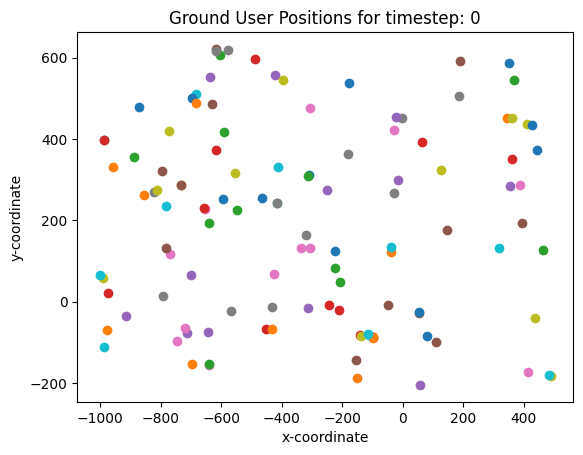

In [9]:
env.plotGUs()

In [10]:
# Using the default isotropic antenna configuration
env.setTransmitterArray()  # For the UAVs
env.setReceiverArray()  # For the Ground Users

In [11]:
# Making each of the UAV's antennas point at the ground
for i in ids:
    env.uavs[i].lookAt()

# We generate the radio map using env.computeRadioMap, then use the visualize method to look at it
radio_map = env.computeRadioMap(max_depth=2, num_samples=10000000, cell_size=(1,1))
    
env.visualize(radio_map=radio_map)